### Necessary Packages

In [1]:
import sys
import os
import torch
import pandas as pd
sys.path.append('../..')
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm
from src.utils import load, load_checkpoint, seed_everything, score
from src.training.resnet_k_fold import create_dataloaders,create_network,Config
from src.models import ResNet
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix,auc,roc_curve,roc_auc_score
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from definitions import *
from functools import reduce

### Global

In [2]:
EXPIREMENT_NAME = 'resnet101'
EXPIREMENT_PATH = os.path.join(EXPIREMENTS_DIR,EXPIREMENT_NAME)
CHECKPOINTS_PATH = os.path.join(EXPIREMENT_PATH,'checkpoints')
CONFIG_PATH = os.path.join(EXPIREMENT_PATH,'config.json')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load configurations

In [3]:
config = Config(**load(CONFIG_PATH))
loaders,test_loader = create_dataloaders(config)

### Reproducibility

In [4]:
seed_everything(config.seed)

### Models loading

In [5]:
def create_models(checkpoints_path : str):

    models = []
    files = sorted(os.listdir(CHECKPOINTS_PATH), key=lambda x: int(x.split('_')[-1].split('.')[0]))

    for checkpoint in tqdm(files):

        model = create_network(config)
        checkpoint = load_checkpoint(os.path.join(checkpoints_path), checkpoint)
        model.load_state_dict(checkpoint['model'])
        model.to(DEVICE)
        model.eval()
        models.append(model)

    return models

In [6]:
models = create_models(CHECKPOINTS_PATH)

  0%|          | 0/5 [00:00<?, ?it/s]

### Make predictions on individual folds

In [7]:
def predict(model: ResNet, dataloader: DataLoader):

    model.eval()

    y_true = []
    y_pred = []

    for x,y in tqdm(dataloader):

        x = x.to(DEVICE)
        y_hat = model.predict(x).detach().cpu().numpy()

        y_true.extend(y.numpy())
        y_pred.extend(y_hat)

    return y_true,y_pred

In [8]:
def predict_all(models: list, dataloaders: list[DataLoader] | DataLoader):
    
    results = {}

    for i,model in enumerate(models):

        if isinstance(dataloaders,list):
            dataloader = dataloaders[i]
        else:
            dataloader = dataloaders

        y_true,y_pred = predict(model,dataloader)

        results[f'fold_{i}'] = pd.DataFrame({
            'y_true': y_true,
            'y_pred': y_pred
        })

    return results

In [9]:
result = predict_all(models,list((val_loader for _,val_loader in loaders)))

  0%|          | 0/2089 [00:00<?, ?it/s]

  0%|          | 0/2089 [00:00<?, ?it/s]

  0%|          | 0/2089 [00:00<?, ?it/s]

  0%|          | 0/2089 [00:00<?, ?it/s]

  0%|          | 0/2089 [00:00<?, ?it/s]

In [10]:
result['fold_0'].head()

,y_true,y_pred
0,0.0,2.209134e-07
1,0.0,1.354390e-05
2,0.0,8.002903e-03
3,0.0,1.804117e-03
4,0.0,2.300466e-09


### Calculate Fold-metrics

In [11]:
def calculate_metrics(y_true : np.ndarray,y_hard : np.ndarray,y_prob : np.ndarray) -> pd.Series:

    accuracy = accuracy_score(y_true,y_hard)
    f1 = f1_score(y_true,y_hard)
    precision = precision_score(y_true,y_hard)
    recall = recall_score(y_true,y_hard)
    roc_auc = roc_auc_score(y_true,y_prob)
    pauc = score(y_true,y_prob)

    results = {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc,
        'pauc': pauc
    }

    return pd.Series(results)

In [12]:
def calculate_all_metrics(result: dict[str,pd.DataFrame]) -> pd.DataFrame:

    metrics = []

    for fold in result.keys():

        y_true = result[fold]['y_true']
        y_pred = np.int32(result[fold]['y_pred'] > 0.5)
        y_prob = result[fold]['y_pred']

        fold_result = calculate_metrics(y_true,y_pred,y_prob)
        fold_result.name = fold

        metrics.append(fold_result)

    metrics = pd.DataFrame(metrics)

    means = metrics.mean(axis=0)
    stds = metrics.std(axis=0)
    metrics.loc['mean'] = means
    metrics.loc['std'] = stds

    return metrics

In [13]:
fold_metrics = calculate_all_metrics(result)

In [14]:
fold_metrics

,accuracy,f1,precision,recall,roc_auc,pauc
fold_0,0.980686,0.048637,0.025463,0.540984,0.932324,0.146326
fold_1,0.980566,0.102281,0.053936,0.986667,0.998088,0.198674
fold_2,0.970139,0.028238,0.014529,0.500000,0.895898,0.122839
fold_3,0.977918,0.048969,0.025763,0.493506,0.920973,0.143736
fold_4,0.980357,0.039503,0.020721,0.421875,0.891950,0.118674
mean,0.977933,0.053525,0.028082,0.588606,0.927847,0.146050
std,0.004504,0.028539,0.015154,0.226613,0.042751,0.031871


<Axes: ylabel='pauc'>

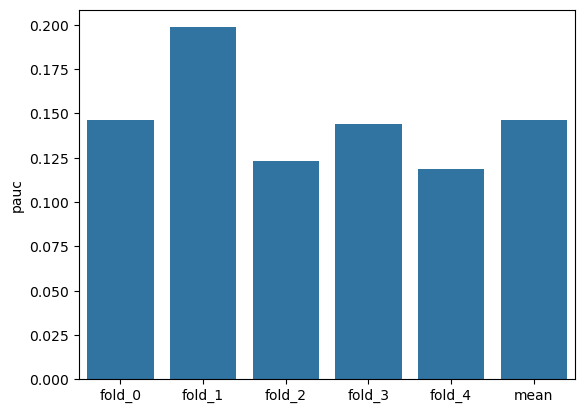

In [15]:
sns.barplot(fold_metrics['pauc'].drop('std'))

### Calculate test-set metrics

In [16]:
test_result = predict_all(models,test_loader)

  0%|          | 0/2089 [00:00<?, ?it/s]

  0%|          | 0/2089 [00:00<?, ?it/s]

  0%|          | 0/2089 [00:00<?, ?it/s]

  0%|          | 0/2089 [00:00<?, ?it/s]

  0%|          | 0/2089 [00:00<?, ?it/s]

In [17]:
test_result['fold_0'].head()

,y_true,y_pred
0,0.0,2.731256e-07
1,0.0,1.177412e-10
2,0.0,6.086444e-06
3,0.0,1.843231e-07
4,0.0,1.111620e-03


In [18]:
test_metrics = calculate_all_metrics(test_result)

In [19]:
test_metrics

,accuracy,f1,precision,recall,roc_auc,pauc
fold_0,0.976348,0.033028,0.017121,0.465517,0.915165,0.139964
fold_1,0.977230,0.026854,0.013944,0.362069,0.868001,0.110167
fold_2,0.967880,0.028067,0.014412,0.534483,0.910831,0.134243
fold_3,0.980671,0.035821,0.018721,0.413793,0.888982,0.113979
fold_4,0.977230,0.026854,0.013944,0.362069,0.868001,0.110167
mean,0.975872,0.030125,0.015628,0.427586,0.890196,0.121704
std,0.004765,0.004077,0.002176,0.073554,0.022561,0.014287


<Axes: ylabel='pauc'>

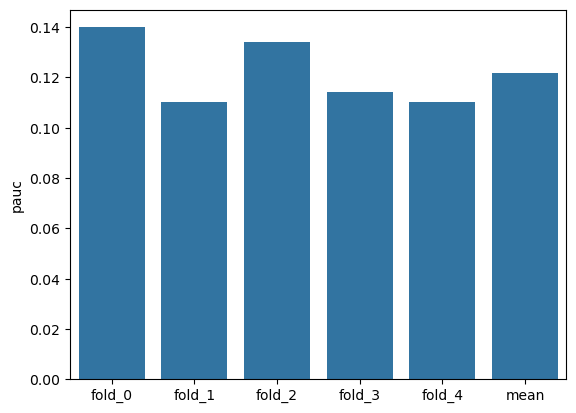

In [20]:
sns.barplot(test_metrics['pauc'].drop('std'))

### The mean of the models

In [21]:
mean = reduce(lambda a,b : a+b,(test_result[key]['y_pred'] for key in test_result.keys())) / len(test_result.keys())

In [22]:
mean_metrcis = calculate_metrics(test_result['fold_0']['y_true'],np.int32(mean > 0.5),mean)
mean_metrcis.name = 'mean'
mean_metrcis

accuracy     0.983409
f1           0.043141
precision    0.022707
recall       0.431034
roc_auc      0.919506
pauc         0.141829
Name: mean, dtype: float64